In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_W5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Mar 20 11:33:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 78%   68C    P2   294W / 370W |  15041MiB / 24268MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 67%   

In [12]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_W5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_360000  save_385000  save_410000  save_440000  save_470000
save_345000  save_365000  save_386768  save_415000  save_445000  save_475000
save_348351  save_370000  save_390000  save_420000  save_450000  save_479080
save_350000  save_375000  save_395000  save_425000  save_455000
save_350857  save_375419  save_400000  save_430000  save_460000
save_355000  save_380000  save_405000  save_435000  save_465000


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 479080

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 132.9MiB
TTS size 45.2MiB
MelEncoder size 14.5MiB
MelDecoder size 28.7MiB
loaded : 386768
386768
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.041109681129455566


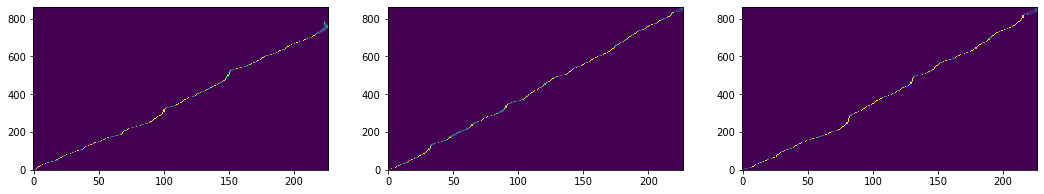

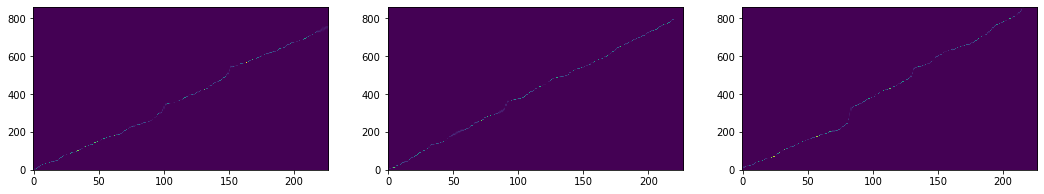

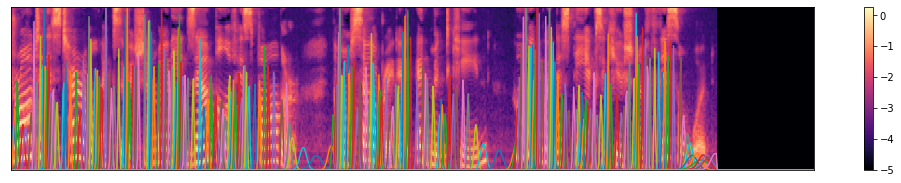

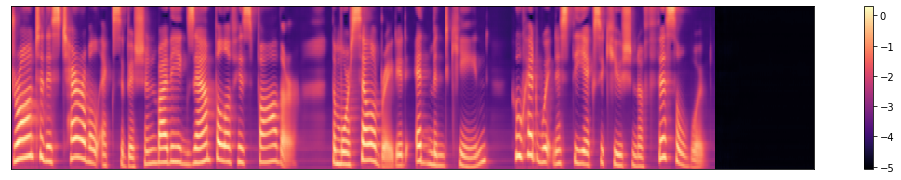

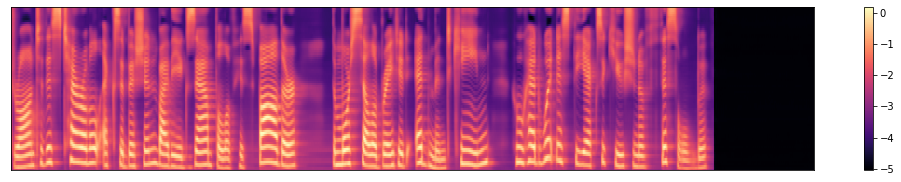

tensor(0.1625, device='cuda:0')
step : 408501 stt : 0.0017 tts : 0.1322 recon : 0.0220 kl : 0.0077 beta : 1.0000
tensor(0.1333, device='cuda:0')
step : 408502 stt : 0.0005 tts : 0.1326 recon : 0.0248 kl : 0.0084 beta : 1.0000
tensor(0.1196, device='cuda:0')
step : 408503 stt : 0.0006 tts : 0.1474 recon : 0.0265 kl : 0.0090 beta : 1.0000
tensor(0.1188, device='cuda:0')
step : 408504 stt : 0.0008 tts : 0.1400 recon : 0.0267 kl : 0.0090 beta : 1.0000
tensor(0.1472, device='cuda:0')
step : 408505 stt : 0.0006 tts : 0.1424 recon : 0.0262 kl : 0.0087 beta : 1.0000
tensor(0.1344, device='cuda:0')
step : 408506 stt : 0.0006 tts : 0.1372 recon : 0.0256 kl : 0.0086 beta : 1.0000
tensor(0.1271, device='cuda:0')
step : 408507 stt : 0.0005 tts : 0.1362 recon : 0.0253 kl : 0.0084 beta : 1.0000
tensor(0.1241, device='cuda:0')
step : 408508 stt : 0.0007 tts : 0.1405 recon : 0.0265 kl : 0.0089 beta : 1.0000
tensor(0.1336, device='cuda:0')
step : 408509 stt : 0.0016 tts : 0.1448 recon : 0.0252 kl : 0.00

tensor(0.1144, device='cuda:0')
step : 408574 stt : 0.0007 tts : 0.1537 recon : 0.0291 kl : 0.0094 beta : 1.0000
tensor(0.2434, device='cuda:0')
step : 408575 stt : 0.0010 tts : 0.1454 recon : 0.0283 kl : 0.0092 beta : 1.0000
tensor(0.1291, device='cuda:0')
step : 408576 stt : 0.0008 tts : 0.1468 recon : 0.0252 kl : 0.0086 beta : 1.0000
tensor(0.1344, device='cuda:0')
step : 408577 stt : 0.0004 tts : 0.1427 recon : 0.0241 kl : 0.0080 beta : 1.0000
tensor(0.1458, device='cuda:0')
step : 408578 stt : 0.0003 tts : 0.1476 recon : 0.0263 kl : 0.0088 beta : 1.0000
tensor(0.1303, device='cuda:0')
step : 408579 stt : 0.0013 tts : 0.1430 recon : 0.0261 kl : 0.0088 beta : 1.0000
tensor(0.1260, device='cuda:0')
step : 408580 stt : 0.0005 tts : 0.1353 recon : 0.0257 kl : 0.0087 beta : 1.0000
tensor(0.1239, device='cuda:0')
step : 408581 stt : 0.0007 tts : 0.1434 recon : 0.0271 kl : 0.0091 beta : 1.0000
tensor(0.1372, device='cuda:0')
step : 408582 stt : 0.0004 tts : 0.1390 recon : 0.0255 kl : 0.00

tensor(0.1591, device='cuda:0')
step : 408647 stt : 0.0005 tts : 0.1533 recon : 0.0272 kl : 0.0089 beta : 1.0000
tensor(0.1181, device='cuda:0')
step : 408648 stt : 0.0004 tts : 0.1423 recon : 0.0276 kl : 0.0091 beta : 1.0000
tensor(0.1270, device='cuda:0')
step : 408649 stt : 0.0003 tts : 0.1367 recon : 0.0261 kl : 0.0087 beta : 1.0000
tensor(0.1482, device='cuda:0')
step : 408650 stt : 0.0006 tts : 0.1478 recon : 0.0271 kl : 0.0089 beta : 1.0000
tensor(0.1192, device='cuda:0')
step : 408651 stt : 0.0006 tts : 0.1397 recon : 0.0263 kl : 0.0088 beta : 1.0000
tensor(0.1110, device='cuda:0')
step : 408652 stt : 0.0003 tts : 0.1358 recon : 0.0264 kl : 0.0088 beta : 1.0000
tensor(0.6796, device='cuda:0')
step : 408653 stt : 0.0021 tts : 0.1449 recon : 0.0242 kl : 0.0083 beta : 1.0000
tensor(0.1105, device='cuda:0')
step : 408654 stt : 0.0006 tts : 0.1432 recon : 0.0279 kl : 0.0091 beta : 1.0000
tensor(0.1170, device='cuda:0')
step : 408655 stt : 0.0005 tts : 0.1375 recon : 0.0251 kl : 0.00

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [67]:
logger.save(step, model, optimizer)

saved save/model_W5G/save_386768


The earliest book printed with movable type, the aforesaid Gutenberg Bible, is printed in letters which are an exact imitation
torch.Size([1, 80, 708]) 0.03781898021697998
{'alignment': 0.0003094673156738281, 'random': 0.0017800331115722656, 'last_conv': 0.026863813400268555, 'z_proj': 0.000659942626953125, 'cond': 0.0009357929229736328, 'up': 0.0011742115020751953, 'encode': 0.004072427749633789, 'pad': 2.6464462280273438e-05, 'enc_conv': 0.0008444786071777344, 'enc_lstm': 0.003042936325073242}


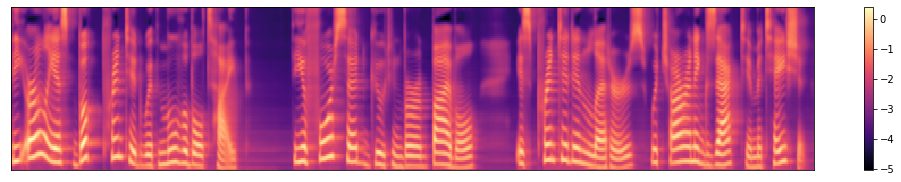

In [65]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 20:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [66]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(181248,)


['F', 'AO1', 'R', ' ', 'AO2', 'L', 'DH', 'OW1', ' ', 'DH', 'AH0', ' ', 'CH', 'AY0', 'N', 'IY1', 'Z', ' ', 'T', 'UH1', 'K', ' ', 'IH0', 'M', 'P', 'R', 'EH1', 'SH', 'AH0', 'N', 'Z', ' ', 'F', 'R', 'AH1', 'M', ' ', 'W', 'UH1', 'D', ' ', 'B', 'L', 'AA1', 'K', 'S', ' ', 'IH0', 'N', 'G', 'R', 'EY1', 'V', 'D', ' ', 'IH0', 'N', ' ', 'R', 'IH0', 'L', 'IY1', 'F', ' ', 'F', 'AO1', 'R', ' ', 'S', 'EH1', 'N', 'CH', 'ER0', 'IY0', 'Z', ' ', 'B', 'IH0', 'F', 'AO1', 'R', ' ', 'DH', 'AH0', ' ', 'W', 'UH1', 'D', 'K', 'AH2', 'T', 'ER0', 'Z', ' ', 'AH1', 'V', ' ', 'DH', 'AH0', ' ', 'N', 'EH1', 'DH', 'ER0', 'L', 'AH0', 'N', 'D', 'Z', ' ', ',', ' ', 'B', 'AY1', ' ', 'AH0', ' ', 'S', 'IH1', 'M', 'AH0', 'L', 'ER0', ' ', 'P', 'R', 'AA1', 'S', 'EH2', 'S', ' ', '.']


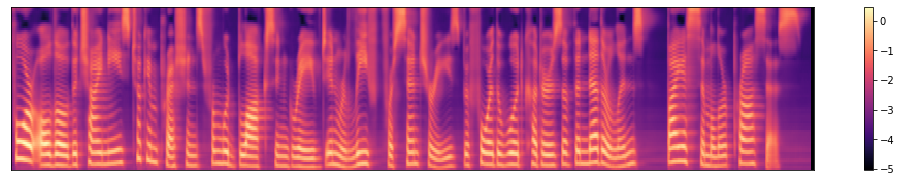

(199424,)


In [32]:
from g2p_en import G2p

g2p = G2p()
text = "For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process."
text_array = g2p(text)
print(text_array)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():

    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)